# TTim: compute per log time interval

Import packages

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import exp1

use_fork = True
if use_fork:
    sys.path.insert(1, "../..")
import ttim

# check which ttim
print("ttim:", ttim.__file__)

ttim: /Users/mark/git/ttim/docs/03examples/../../ttim/__init__.py


Compare to analytical Theis solution.

In [2]:
def theis(r, t, T, S, Q):
    u = r**2 * S / (4 * T * t)
    h = -Q / (4 * np.pi * T) * exp1(u)
    return h


def theisQr(r, t, T, S, Q):
    u = r**2 * S / (4 * T * t)
    return -Q / (2 * np.pi) * np.exp(-u) / r


Model parameters

In [3]:
T = 500
S = 1e-4
t = np.logspace(-5, 0, 11)
r = 30
Q = 788

In [4]:
htheis = theis(r, t, T, S, Q)
Qrtheis = theisQr(r, t, T, S, Q)

In [5]:
tmin = 1e-5
tmax = 1.0

ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=S / 20, tmin=tmin, tmax=tmax)
w = ttim.Well(ml, tsandQ=[(0, Q)], rw=1e-5)
ml.solve()

self.neq  1
solution complete


In [6]:
h = np.full_like(t, np.nan)
for i, ti in enumerate(t[:-1]):
    h[i] = ml.head(30, 0, ti).item()  # .item() to get scalar value

The TTim solution still matches the analytical Theis solution. 

Note that the final time could not be computed yet because the new implementation does not expand the time last time interval to contain `t=1.0`.

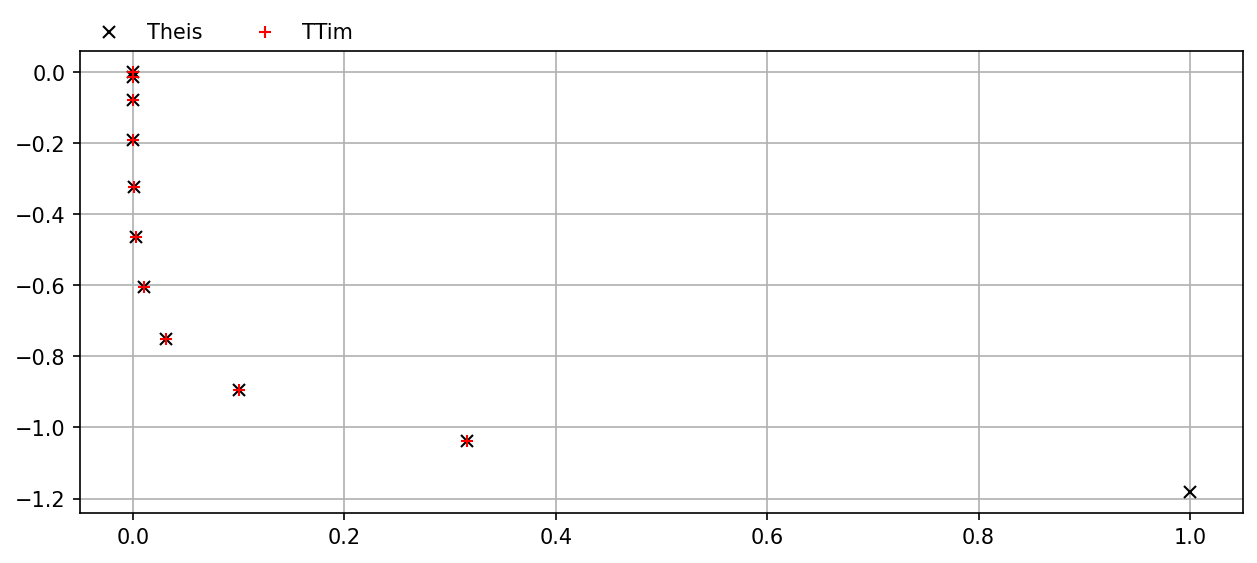

In [7]:
plt.subplots(1, 1, figsize=(10, 4), dpi=150)
plt.plot(t, htheis, "x", c="k", label="Theis")
plt.plot(t, h, "+", c="r", label="TTim")
plt.legend(loc=(0, 1), frameon=False, ncol=2)
plt.grid()

But this allows us to demonstrate a new feature. We can solve for a specific time interval using `ml.solve_interval()`. 

In [8]:
# solve interval
ml.solve_interval(0)
# compute head at time
h[-1] = ml.head(30, 0, t[-1]).item() # .item() not strictly needed here

Plot figure again.

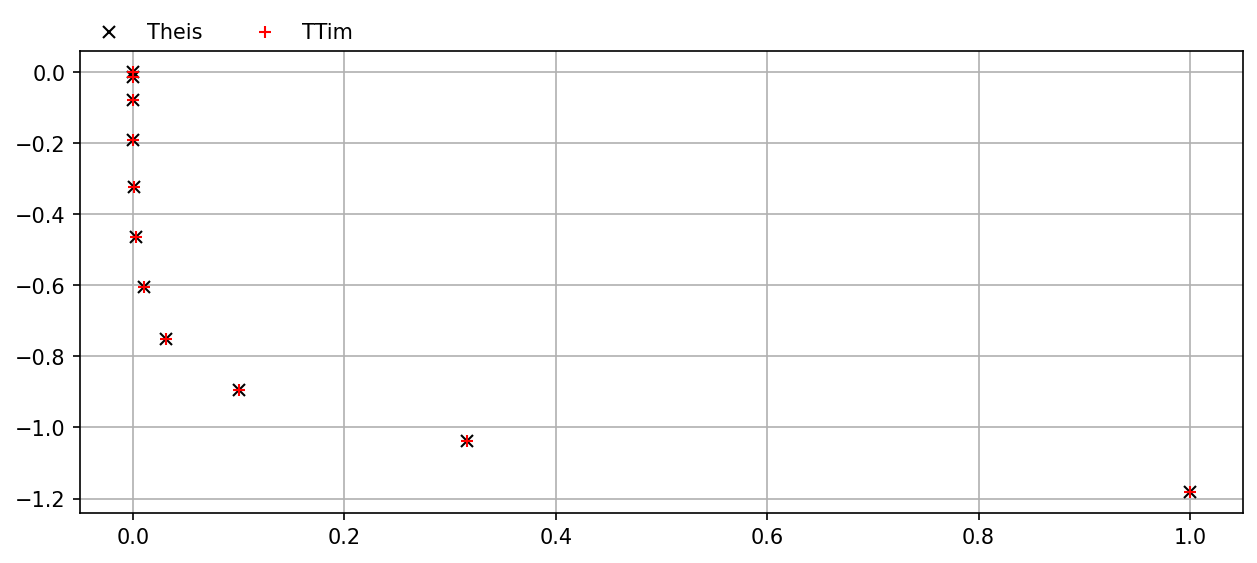

In [9]:
plt.subplots(1, 1, figsize=(10, 4), dpi=150)
plt.plot(t, htheis, "x", c="k", label="Theis")
plt.plot(t, h, "+", c="r", label="TTim")
plt.legend(loc=(0, 1), frameon=False, ncol=2)
plt.grid()

The differences:

In [10]:
h - htheis

array([ 6.37189134e-09, -2.42570941e-10, -7.62565022e-08, -3.67057912e-10,
       -8.43733611e-07, -1.44393814e-09,  2.36600560e-07, -2.87300783e-09,
        2.00696027e-06, -3.10441273e-09,  3.31500919e-06])

### Hantush

In [11]:
# Hantush solution from Bakker and Post
from scipy.integrate import quad

def integrand(tau, r, T, lab):
    return 1 / tau * np.exp(-tau - r ** 2 / (4 * lab ** 2 * tau))

def hantush(r, t, T, S, c, Q):
    lab = np.sqrt(T * c)
    u = S * r ** 2 / (4 * T * t)
    F = quad(integrand, u, np.inf, args=(r, T, lab))[0]
    return -Q / (4 * np.pi * T) * F

hantushvec = np.vectorize(hantush) # vectorized version of hantush function

In [12]:
T = 500  # transmissivity
S = 1e-4
time = np.logspace(-2, 2, 101)
r = 20
Q = 1000
c = 1e3

ml = ttim.ModelMaq(
        kaq=25, z=[21, 20, 0], c=c, Saq=S / 20, topboundary="semi", tmin=0.01, tmax=1000
    )
w = ttim.Well(ml, tsandQ=[(0, Q)], rw=1e-5)
ml.solve()
ml.head(r, 0, 10)
hhantush = np.zeros(len(time))
hantushexact = np.zeros(len(time))
for i, t in enumerate(time):
    hhantush[i] = ml.head(r, 0, t)[0]
    hantushexact[i] = hantush(r, t, T, S, c, Q)

self.neq  1
solution complete


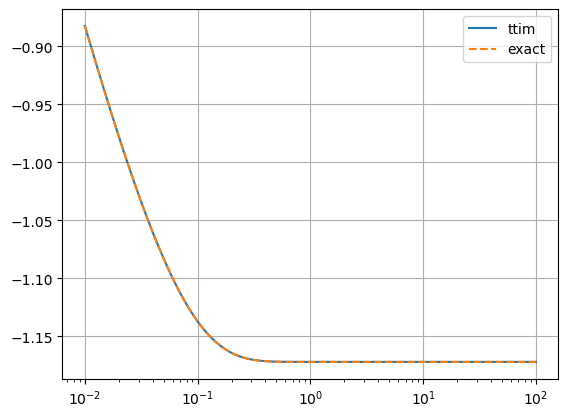

In [13]:
plt.semilogx(time, hhantush, label='ttim')
plt.semilogx(time, hantushexact, '--', label='exact')
plt.legend()
plt.grid()

### Multi-layers

In [36]:
k = 25
H = 20
Ss = 1e-4 / H
t = np.logspace(-3, 1, 100)
Q = 500
rw = 0.2
#ml = ttim.ModelMaq(kaq=k, z=[H, 0], tmin=1e-3, tmax=10)
ml = ttim.Model3D(kaq=k, z=np.linspace(H, 0, 4), Saq=Ss, tmin=1e-3, tmax=10)
w = ttim.Well(ml, tsandQ=[(0, Q)], rw=rw, layers=[0])

ml.solve()

self.neq  1


ValueError: could not broadcast input array from shape (0,3,21) into shape (0,1,21)

In [37]:
w.nunknowns

1

In [35]:
t_int = 0
w.potinflayers(w.xc[0], w.yc[0], t_int, w.layers).shape

AttributeError: 'Well' object has no attribute 'xc'

In [29]:
w.potinflayers??

Signature: w.potinflayers(x, y, t_int, layers=0, aq=None)
Source:   
    def potinflayers(self, x, y, t_int, layers=0, aq=None):
        """Layers can be scalar, list, or array.

        returns array of size (len(layers),nparam,npval) only used in building equations
        """
        if aq is None:
            aq = self.model.aq.find_aquifer_data(x, y)
        pot = self.potinf(x, y, t_int, aq)
        rv = pot * aq.eigvec[t_int]
        # first axis needs to be the number of layers
        rv = rv.swapaxes(0, 1)
        return rv[layers, :]
File:      ~/git/ttim/ttim/element.py
Type:      method

In [31]:
w.potinf(2, 3, t_int).shape

(1, 1, 21)

In [33]:
w.potinf??

Signature: w.potinf(x, y, t_int, aq=None)
Source:   
    def potinf(self, x, y, t_int, aq=None):
        """Can be called with only one x, y value for log time interval t_int."""
        if aq is None:
            aq = self.model.aq.find_aquifer_data(x, y)
        rv = np.zeros((self.nparam, aq.naq, self.model.nppar), dtype=complex)
        if aq == self.aq:
            r = np.sqrt((x - self.xw) ** 2 + (y - self.yw) ** 2)
            pot = np.zeros(self.model.nppar, dtype=complex)
            if r < self.rw:
                r = self.rw  # If at well, set to at radius
            for i in range(self.aq.naq):
                lab_t = self.aq.lab[t_int]
                if r / abs(lab_t[i, 0]) < self.rzero:
                    pot[:] = kv(0, r / lab_t[i, :])
                    rv[:, i, :] = self.term[t_int][:, i, :] * pot
        return rv
File:      ~/git/ttim/ttim/well.py
Type:      method